# Predicting Which Subreddit A Post Comes From

One of the most polarizing issues that has dominated headlines over the past year or so is Robert Mueller's investigation into connections between the 2016 Trump campaign and Russia. There has been a ton of discussion on cable news networks, in newspaper articles, and online about the investigation and all of the updates going along with it. For this project, I wanted to invesigate how this discussion was playing out across the website [reddit](http://www.reddit.com). Specifically, I wanted to look at the the subreddits [r/The_Donald](http://the_donald.reddit.com) and [r/The_Mueller](http://the_mueller.reddit.com) as I assumed that these two subreddits would represent different sides of the same issue. 

## Step 1: Defining the Problem

The problem here is twofold:
1. What are the most important features in predicting the subreddit that a post is from?
2. What is the most accurate prediction model that I can build to identify which subreddit a post is from?


## Step 2: Gathering Data
### Scraping Thread Info from Reddit.com

In [1]:
import requests
import json
import praw
import time
import pandas as pd
import numpy as np

In [2]:
# Create both URLs for the subreddits
URL1 = "https://www.reddit.com/r/The_Mueller/top.json"
URL2 = "https://www.reddit.com/r/The_Donald/top.json"

In [3]:
# Create payload with parameters and request results for both URLs
payload = {'t': 'year'}
res1 = requests.get(URL1, headers={"User-agent": "Zeke Bot 0.1"}, params= payload)
res2 = requests.get(URL2, headers={"User-agent": "Zeke Bot 0.1"}, params= payload)

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

In [4]:
data1 = res1.json()
data2 = res2.json()

In [5]:
# Create instance of reddit with details for scraper script I set up in reddit
reddit = praw.Reddit(user_agent='Comment Extraction',
                     client_id='7WcXxxBHvnT7cA', client_secret="ZJOOdCaK3jG4zYvX3KcABjZ4xxk",
                     username= 'reddit_scraper_dsi', password = 'Scraper!')

# Set reddit to read only to avoid accidentally posting
reddit.read_only = True

In [6]:
post_list = []

for i in range(25):
    my_dict1 = data1['data']['children'][i]['data']
    my_dict2 = data2['data']['children'][i]['data']
        
    # Create instance of submission
    submission1 = reddit.submission(id = data1['data']['children'][i]['data']['id'])
    submission2 = reddit.submission(id = data2['data']['children'][i]['data']['id'])

    # Remove all MoreComments objects from the list of comments
    submission1.comments.replace_more(limit=0)
    submission2.comments.replace_more(limit=0)

    # Create a list of all top level comments
    comment_text1 = [top_level_comment.body for top_level_comment in submission1.comments 
                     if top_level_comment.author != 'AutoModerator']
    comment_text2 = [top_level_comment.body for top_level_comment in submission2.comments 
                     if top_level_comment.author != 'AutoModerator']

    # Add comments to dictionary
    my_dict1['comments'] = comment_text1
    my_dict2['comments'] = comment_text2

    # Append dictionary to post_list
    post_list.append(my_dict1)
    post_list.append(my_dict2)

df = pd.DataFrame(post_list)
df.head()

,approved_at_utc,approved_by,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,...,thumbnail_height,thumbnail_width,title,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,None,None,False,timmyJACK,None,None,[],None,None,None,...,140.0,140.0,Traitor. Upvote this so that people see it whe...,139149,https://i.redd.it/96l7405etea11.jpg,[],None,False,house_only,1
1,None,None,True,mbp4295,None,None,[],None,None,None,...,131.0,140.0,The rest hid like cowards!,20255,https://i.redd.it/jrskryzmtvnz.jpg,[],None,False,house_only,1
2,None,None,True,npor,None,None,[],None,None,None,...,140.0,140.0,Let's give this American the upvotes he deserves,91308,https://i.redd.it/ufiypfh52zuz.jpg,[],None,False,house_only,1
3,None,None,True,PepeTheRacistFrog,None,None,[],None,None,None,...,140.0,140.0,"This Is Not A Partisan Issue. 300,000,000 Amer...",19882,https://i.redd.it/ofa6sxay2tpz.jpg,[],None,False,house_only,1
4,None,None,False,stupidstupidreddit,None,None,[],None,None,None,...,93.0,140.0,It would be a shame if the newly obtained phot...,89392,https://i.redd.it/qkpp4jnc85e11.jpg,[],None,False,house_only,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 97 columns):
approved_at_utc                  0 non-null object
approved_by                      0 non-null object
archived                         50 non-null bool
author                           50 non-null object
author_flair_background_color    25 non-null object
author_flair_css_class           20 non-null object
author_flair_richtext            46 non-null object
author_flair_template_id         7 non-null object
author_flair_text                21 non-null object
author_flair_text_color          25 non-null object
author_flair_type                46 non-null object
author_fullname                  46 non-null object
banned_at_utc                    0 non-null object
banned_by                        0 non-null object
can_gild                         50 non-null bool
can_mod_post                     50 non-null bool
category                         0 non-null object
clicked                  

In [8]:
df.to_csv('raw_reddit_scrape.csv')

#### Getting more results

By default, Reddit will give you the top 25 posts. The cell below uses a for loop to collect as much data as possible. The subreddit [r/The_Mueller](http://the_mueller.reddit.com) had fewer than 1000 posts for me to collect, so I instead collected 975. To keep the classes balanced, I collected the same number of posts from [r/The_Donald](http://the_donald.reddit.com)

In [9]:
for j in range(1, 39):
    # Create empty list of dictionaries to append to dataframe
    post_list = []
    
    # Find the afters for each of the urls
    after1 = data1['data']['after']
    after2 = data2['data']['after']
    
    # Create parameter dictionaries for both urls
    payload1 = {'t': 'year', 'after': after1}
    payload2 = {'t': 'year', 'after': after2}
    
    # Create both urls
    url_temp1 = 'https://www.reddit.com/r/The_Mueller/top.json'
    url_temp2 = 'https://www.reddit.com/r/The_Donald/top.json'
    
    # Get with requests from both urls
    res1 = requests.get(url_temp1, headers={'User-agent': 'Zeke Bot 0.1'}, params = payload1)
    res2 = requests.get(url_temp2, headers={'User-agent': 'Zeke Bot 0.1'}, params = payload2)
    
    # Replace values of data1 and data2
    data1, data2 = res1.json(), res2.json()
    
    # Iterate through all children of first subreddit (posts)
    for i in range(len(data1['data']['children'])):
        
        # Create dictionaries from json
        my_dict1 = data1['data']['children'][i]['data']
        
        # Create instance of submission
        submission1 = reddit.submission(id = data1['data']['children'][i]['data']['id'])
        
        # Remove all MoreComments objects from the list of comments
        submission1.comments.replace_more(limit=0)
        
        # Create a list of all top level comments
        comment_text1 = [top_level_comment.body for top_level_comment in submission1.comments 
                         if top_level_comment.author != 'AutoModerator']
        
        # Add comments to dictionary
        my_dict1['comments'] = comment_text1
        
        # Append dictionary to post_list
        post_list.append(my_dict1)

    # Iterate through all children of second subreddit (posts)
    for i in range(len(data2['data']['children'])):
        
        # Create dictionaries from json
        my_dict2 = data2['data']['children'][i]['data']
        
        # Create instance of submission
        submission2 = reddit.submission(id = data2['data']['children'][i]['data']['id'])
        
        # Remove all MoreComments objects from the list of comments
        submission2.comments.replace_more(limit=0)
        
        # Create a list of all top level comments
        comment_text2 = [top_level_comment.body for top_level_comment in submission2.comments 
                         if top_level_comment.author != 'AutoModerator']
        
        # Add comments to dictionary
        my_dict2['comments'] = comment_text2
        
        # Append dictionary to post_list
        post_list.append(my_dict2)

    # Add post list to dataframe and save dataframe after each set of 25 posts has been processed
    temp_df = pd.DataFrame(post_list)
    df = pd.concat([df, temp_df], axis=0, ignore_index=True)
    df.to_csv('../Data/raw_reddit_scrape.csv')
        
    print('Loop Number:', j, 'df shape:', df.shape)    
    time.sleep(3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



Loop Number: 1 df shape: (100, 97)
Loop Number: 2 df shape: (150, 98)
Loop Number: 3 df shape: (200, 98)
Loop Number: 4 df shape: (250, 98)
Loop Number: 5 df shape: (300, 98)
Loop Number: 6 df shape: (350, 98)
Loop Number: 7 df shape: (400, 98)
Loop Number: 8 df shape: (450, 98)
Loop Number: 9 df shape: (500, 98)
Loop Number: 10 df shape: (550, 98)
Loop Number: 11 df shape: (600, 98)
Loop Number: 12 df shape: (650, 98)
Loop Number: 13 df shape: (700, 98)
Loop Number: 14 df shape: (750, 98)
Loop Number: 15 df shape: (800, 98)
Loop Number: 16 df shape: (850, 98)
Loop Number: 17 df shape: (900, 98)
Loop Number: 18 df shape: (950, 98)
Loop Number: 19 df shape: (1000, 98)
Loop Number: 20 df shape: (1050, 98)
Loop Number: 21 df shape: (1100, 98)
Loop Number: 22 df shape: (1150, 98)
Loop Number: 23 df shape: (1200, 98)
Loop Number: 24 df shape: (1250, 98)
Loop Number: 25 df shape: (1300, 98)
Loop Number: 26 df shape: (1350, 98)
Loop Number: 27 df shape: (1400, 98)
Loop Number: 28 df shape: (1

### Save the results as a CSV

In [10]:
# Export to csv
df.to_csv('../Data/raw_reddit_scrape.csv')

In [11]:
df.shape

(1950, 98)

## Step 3: EDA and Data Cleaning

In [12]:
# Check for null values
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

view_count                       1950
num_reports                      1950
approved_by                      1950
banned_at_utc                    1950
banned_by                        1950
category                         1950
content_categories               1950
mod_note                         1950
mod_reason_by                    1950
mod_reason_title                 1950
likes                            1950
approved_at_utc                  1950
removal_reason                   1950
report_reasons                   1950
distinguished                    1944
author_cakeday                   1936
suggested_sort                   1933
selftext_html                    1929
crosspost_parent_list            1909
crosspost_parent                 1909
previous_visits                  1887
secure_media                     1881
media                            1881
author_flair_template_id         1679
link_flair_template_id           1461
link_flair_css_class             1175
link_flair_t

In [20]:
# Make a copy of df to manipulate
red_df = df.copy()

In [21]:
# Drop all columns that contain only null values
null_cols = red_df.isnull().sum()[red_df.isnull().sum() == 1950].keys().tolist()
red_df.drop(labels = null_cols, axis=1, inplace=True)

In [22]:
# Drop all unwanted columns
unwanted_cols = ['preview', 'thumbnail_width', 'thumbnail_height', 'link_flair_template_id','author_cakeday',
                 'suggested_sort', 'media', 'secure_media', 'crosspost_parent_list', 'author_flair_template_id',
                 'author_flair_css_class', 'link_flair_css_class', 'author_flair_background_color',
                 'author_flair_type', 'author_flair_richtext', 'whitelist_status', 'wls',
                 'visited', 'subreddit_id', 'subreddit_subscribers', 'subreddit_name_prefixed', 'can_gild',
                 'author_fullname', 'author_flair_text_color', 'can_mod_post', 'clicked', 'contest_mode',
                 'created', 'created_utc', 'crosspost_parent', 'distinguished', 'hidden', 'edited',
                 'hide_score', 'is_crosspostable', 'is_meta', 'is_original_content', 'link_flair_background_color',
                 'link_flair_text_color', 'link_flair_type', 'link_flair_richtext', 'locked', 'media_only',
                 'no_follow', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
                 'quarantine', 'saved', 'secure_media_embed', 'spoiler', 'stickied', 'subreddit_type', 
                 'user_reports', 'mod_reports', 'previous_visits', 'selftext_html', 'media_embed', 'thumbnail']
red_df.drop(labels=unwanted_cols, axis=1, inplace=True)

In [23]:
# Check to make sure correct columns remain
red_df.columns

Index(['archived', 'author', 'author_flair_text', 'comments', 'domain',
       'downs', 'gilded', 'id', 'is_reddit_media_domain', 'is_self',
       'is_video', 'link_flair_text', 'name', 'num_comments', 'num_crossposts',
       'post_hint', 'score', 'selftext', 'send_replies', 'subreddit', 'title',
       'ups', 'url'],
      dtype='object')

In [24]:
red_df.shape

(1950, 23)

In [25]:
red_df.dtypes

archived                    bool
author                    object
author_flair_text         object
comments                  object
domain                    object
downs                      int64
gilded                     int64
id                        object
is_reddit_media_domain      bool
is_self                     bool
is_video                    bool
link_flair_text           object
name                      object
num_comments               int64
num_crossposts             int64
post_hint                 object
score                      int64
selftext                  object
send_replies                bool
subreddit                 object
title                     object
ups                        int64
url                       object
dtype: object

In [26]:
# Remap True/False to 1/0 for boolean columns
bool_dict = {True: 1, False: 0}

bool_cols = ['archived', 'is_reddit_media_domain', 'is_self', 'is_video', 'send_replies']
for col in bool_cols:
    red_df[col] = red_df[col].map(bool_dict)

In [27]:
# Double check to make sure classes are balanced
red_df['subreddit'].value_counts()

The_Mueller    975
The_Donald     975
Name: subreddit, dtype: int64

In [28]:
# Remap subreddits to 1 and 0, distinction between positive and negative class is arbitrary
red_df['subreddit'] = red_df['subreddit'].map(lambda cell: 1 if cell == 'The_Mueller' else 0)

red_df['subreddit'].value_counts()

1    975
0    975
Name: subreddit, dtype: int64

In [35]:
# Replace null values in both flair text caterogies with empty strings
red_df['author_flair_text'].fillna('', inplace=True)

red_df['link_flair_text'].fillna('', inplace=True)

In [45]:
# Combine two flair text features into one and then drop original features
red_df['flair_text'] = red_df['author_flair_text'] + red_df['link_flair_text']
red_df.drop(['author_flair_text', 'link_flair_text'], axis=1, inplace=True)

In [41]:
len(list(red_df['author'].unique()))

1061

Several features are no longer helpful:
- There are over 1000 unique authors in a dataset comprised of fewer than 2000 posts, so I will not use this feature. 
- The id and name features are also unhelfpul as they are just unique identifiers for each post. 
- The information I'm most interested in from the url feature is captured in the domain feature.

All three features are dropped in the cell below

In [43]:
red_df.drop(['author', 'id', 'url', 'name'], axis=1, inplace=True)

In [50]:
red_df.dtypes

archived                   int64
comments                  object
domain                    object
downs                      int64
gilded                     int64
is_reddit_media_domain     int64
is_self                    int64
is_video                   int64
num_comments               int64
num_crossposts             int64
post_hint                 object
score                      int64
selftext                  object
send_replies               int64
subreddit                  int64
title                     object
ups                        int64
flair_text                object
dtype: object

The last bit of data cleaning to do before moving into NLP is to dummy the post_hint variable. This is done below.

In [53]:
red_df = pd.get_dummies(red_df, columns=['post_hint'], drop_first=True)

Now the data is ready to be processed using NLP methods

In [320]:
red_df.to_csv('../Data/reddit_scrape_cleaned.csv')

## Step 4: Modeling

#### Import necessary modeling and NLP packages

In [767]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier  
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## First Model: title + selftext

In [54]:
# Create X and y and then train/test split
X1 = red_df['title'] + red_df['selftext']
y1 = red_df['subreddit']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=8)

In [321]:
# Instanstiate count vectorizer object and transform X data
cvect = CountVectorizer(stop_words='english')

X1_train_cvect = cvect.fit_transform(X1_train)
X1_test_cvect = cvect.transform(X1_test)

In [322]:
# Instantiate 2 different classifier models
logreg = LogisticRegression()
nb = MultinomialNB()

In [323]:
nb_score = cross_val_score(nb, X1_train_cvect, y1_train)
print(nb_score)
print(nb_score.mean())

[0.70491803 0.73921971 0.74332649]
0.7291547446729728


In [324]:
# Scale data before using logistic regression
ss = StandardScaler()
X1_train_scaled = ss.fit_transform(X1_train_cvect.todense())
X1_test_scaled = ss.transform(X1_test_cvect.todense())

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [325]:
logreg_score = cross_val_score(logreg, X1_train_scaled, y1_train)
print(logreg_score)
print(logreg_score.mean())

[0.68442623 0.69609856 0.65297741]
0.6778340682891799


After creating 2 simple models, a logistic regression and a multinomial naive bayes, it seems the naive bayes had a slightly better fit. Both models still have a lot of room for improvement. Below I will check for overfit on each model.

In [788]:
logreg.fit(X1_train_cvect, y1_train)
m1_log_score = logreg.score(X1_test_scaled, y1_test)
log_scores = [m1_log_score]
print('Train Score:', logreg.score(X1_train_scaled, y1_train))
print('Test Score:', logreg.score(X1_test_scaled, y1_test))

Train Score: 0.981532147742818
Test Score: 0.7028688524590164


In [789]:
nb.fit(X1_train_cvect, y1_train)
m1_nb_score = nb.score(X1_test_cvect, y1_test)
nb_scores = [m1_nb_score]
print('Train Score:', nb.score(X1_train_cvect, y1_train))
print('Test Score:', nb.score(X1_test_cvect, y1_test))

Train Score: 0.9411764705882353
Test Score: 0.7438524590163934


In [328]:
len(cvect.get_feature_names())

5688

In [329]:
word_count = 0
for i in X1.index:
    word_count += len(X1[i].split())
print(word_count/1950)

20.466153846153848


I will attempt this again with a TfidfVectorizer instead of a count vectorizer

In [716]:
tvect = TfidfVectorizer()
tvect.fit(X1_train)

X1_train_tvect = tvect.transform(X1_train)
X1_test_tvect = tvect.transform(X1_test)

In [717]:
logreg_t = LogisticRegression()
nb_t = MultinomialNB()

In [718]:
nb_t.fit(X1_train_tvect, y1_train)
m1_nbt_score = nb_t.score(X1_test_tvect, y1_test)
print(m1_nbt_score)

0.7418032786885246


In [720]:
ss_t = StandardScaler()
X1_train_t_scaled = ss_t.fit_transform(X1_train_tvect.todense())
X1_test_t_scaled = ss_t.transform(X1_test_tvect.todense())

In [721]:
logreg_t.fit(X1_train_t_scaled, y1_train)
m1_logt_score = logreg_t.score(X1_test_t_scaled, y1_test)
print(m1_logt_score)

0.6885245901639344


In [726]:
m1_scores = [
    {'score':m1_log_score, 
     'vectorizer': 'CountVectorizer',
     'classifier': 'LogisticRegression'
    },
    {'score':m1_nb_score, 
     'vectorizer': 'CountVectorizer',
     'classifier': 'MultinomialNB'
    },
    {'score':m1_logt_score, 
     'vectorizer': 'TfidfVectorizer',
     'classifier': 'LogisticRegression'
    },
    {'score':m1_nbt_score, 
     'vectorizer': 'TfidfVectorizer',
     'classifier': 'MultinomialNB'
    }]
m1_scores=pd.DataFrame(m1_scores)
m1_scores


,classifier,score,vectorizer
0,LogisticRegression,0.702869,CountVectorizer
1,MultinomialNB,0.743852,CountVectorizer
2,LogisticRegression,0.688525,TfidfVectorizer
3,MultinomialNB,0.741803,TfidfVectorizer


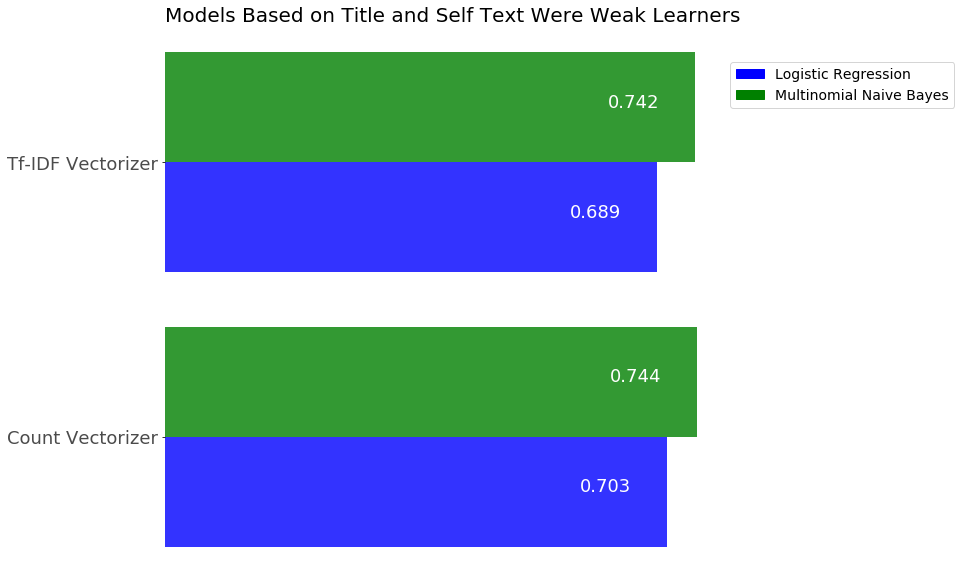

In [927]:
plt.figure(figsize=(10,10))
plt.barh([0, .8, 2.0, 2.8],
         m1_scores['score'],
         color = ['b', 'g', 'b', 'g'],
         alpha = 0.8,
         label=m1_scores['classifier'])
plt.yticks([])
plt.xticks([])
plt.title("Models Based on Title and Self Text Were Weak Learners", size=20, ha='left', position=(0,1))
ax = plt.gca()
sides = ['left', 'right', 'top', 'bottom']
for side in sides:
    ax.spines[side].set_visible(False)
plt.yticks([0.4, 2.4], ['Count Vectorizer', 'Tf-IDF Vectorizer'], size=18, alpha=0.7)
blue_patch = mpatches.Patch(color='b', label='Logistic Regression')
green_patch = mpatches.Patch(color='g', label='Multinomial Naive Bayes')
plt.legend(handles=[blue_patch, green_patch], bbox_to_anchor=(1,0.95), prop={'size': 14})
barh_y_vals = [0, .8, 2.0, 2.8]
for i in range(4):
    plt.text(m1_scores.loc[i,'score']-.05,
             barh_y_vals[i],
             str(round(m1_scores.loc[i,'score'],3)),
             color='w',
             size=18,
             ha='right')
plt.savefig('./Assets/model_1.png', bbox_inches='tight')

Both models were severely overfit, performing significantly better on training data than on testing data. This may be because of the small amount of information being used for each prediction relative to the number of features. There are over 5500 features in the prediction matrix, while the average number of words being evaluated for each post is only about 20. In order to make this model more accurate, I will try introducing more data.

## Model 2: Add all numeric metadata

In [135]:
X2 = pd.concat([red_df.select_dtypes('int64'), red_df['title'] + red_df['selftext']], axis=1).drop('subreddit', axis=1)
y2 = red_df['subreddit']

In [136]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [137]:
cvect2 = CountVectorizer(stop_words='english')

cvect2.fit(X2_train[0])
X2_train_cv = pd.DataFrame(cvect2.transform(X2_train[0]).todense(), columns=cvect2.get_feature_names(), index=X2_train.index)
X2_test_cv =  pd.DataFrame(cvect2.transform(X2_test[0]).todense(), columns=cvect2.get_feature_names(), index=X2_test.index)

In [138]:
X2_train = pd.concat([X2_train.drop(0, axis=1), X2_train_cv], axis=1)
X2_test = pd.concat([X2_test.drop(0, axis=1), X2_test_cv], axis=1)

In [139]:
logreg2 = LogisticRegression()
nb2 = MultinomialNB()

In [140]:
nb2_score = cross_val_score(nb2, X2_train, y2_train)
print(nb2_score)
print(nb2_score.mean())

[0.79918033 0.79098361 0.73045267]
0.7735388697744496


In [141]:
ss2 = StandardScaler()

X2_train_scaled = ss2.fit_transform(X2_train)
X2_test_scaled = ss2.transform(X2_test)

In [142]:
logreg2_score = cross_val_score(logreg2, X2_train_scaled, y2_train)
print(logreg2_score)
print(logreg2_score.mean())

[0.78483607 0.71516393 0.76337449]
0.7544581618655694


Including this information made both models stronger. I will check both models on the testing data below to see how they perform.

In [791]:
logreg2.fit(X2_train_scaled, y2_train)
log_scores.append(logreg2.score(X2_test_scaled, y2_test))
print('Train score:', logreg2.score(X2_train_scaled, y2_train))
print('Test score:', logreg2.score(X2_test_scaled, y2_test))

Train score: 0.9986320109439124
Test score: 0.7745901639344263


In [790]:
nb2.fit(X2_train, y2_train)
nb_scores.append(nb2.score(X2_test, y2_test))
print('Train score:', nb2.score(X2_train, y2_train))
print('Test score:', nb2.score(X2_test, y2_test))

Train score: 0.8242134062927496
Test score: 0.7479508196721312


### Model 3: Add Flair Text and Domain dummies

In [146]:
X2.columns

Index([              'archived',                  'downs',
                       'gilded', 'is_reddit_media_domain',
                      'is_self',               'is_video',
                 'num_comments',         'num_crossposts',
                        'score',           'send_replies',
                          'ups',                        0],
      dtype='object')

In [252]:
tokenizer = RegexpTokenizer(r'(\w+)\.\w{2}\.\w{2}|\w+\.(\w+)\.\S*|(\w+)\.\S*')

In [253]:
def domain_tokenizer(x):
    tokens = tokenizer.tokenize(x)
    token = [a for a in tokens[0] if a != '']
    return token[0]

In [255]:
red_df['domain'] = red_df['domain'].map(domain_tokenizer)

0                 redd
1                 redd
2                 redd
3                 redd
4                 redd
5              foxnews
6                 redd
7              magaimg
8                imgur
9              twitter
10            newsweek
11             twitter
12                redd
13                redd
14                redd
15               imgur
16               imgur
17                redd
18               imgur
19              nypost
20                redd
21                redd
22                redd
23                redd
24         motherjones
25             archive
26                redd
27              nypost
28                redd
29                redd
             ...      
1920          theonion
1921           twitter
1922          chicago2
1923             imgur
1924    chicagotribune
1925           thehill
1926              self
1927             imgur
1928              redd
1929              redd
1930              redd
1931           archive
1932       

In [224]:
X3 = pd.concat([X2, red_df['flair_text'], pd.get_dummies(red_df['domain'], prefix='domain', drop_first=True)], axis=1)
y3 = red_df['subreddit']

In [332]:
# Create custom stop words from nltk and sklearn stop words together
s1 = set(ENGLISH_STOP_WORDS)
s2 = set(stopwords.words('english'))
len(s1), len(s2)

(318, 179)

In [334]:
# Combine both sets of stopwords into a set
stops = s1.union(s2)
len(stops)

378

In [350]:
# Create count vectorizers for each text feature
cv3_title = CountVectorizer(stop_words=stops)
cv3_flair = CountVectorizer(stop_words=stops)

In [351]:
# Train test split data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [352]:
# Transform the train and test data from the title column (labeled 0)
# Make the transformed sparse matrix into a dataframe with appropriate feature names
cv3_title.fit(X3_train[0])
X3_train_title_vect = pd.DataFrame(cv3_title.transform(X3_train[0]).todense(),
                                   columns = cv3_title.get_feature_names(),
                                   index = X3_train.index)
X3_test_title_vect = pd.DataFrame(cv3_title.transform(X3_test[0]).todense(),
                                  columns = cv3_title.get_feature_names(),
                                  index = X3_test.index)

In [353]:
# Transform the train and test data from the flair_text column 
# Make the transformed sparse matrix into a dataframe with appropriate feature names
cv3_flair.fit(X3_train['flair_text'])
X3_train_flair_vect = pd.DataFrame(cv3_flair.transform(X3_train['flair_text']).todense(),
                                   columns = cv3_flair.get_feature_names(),
                                   index = X3_train.index)
X3_test_flair_vect = pd.DataFrame(cv3_flair.transform(X3_test['flair_text']).todense(),
                                  columns = cv3_flair.get_feature_names(),
                                  index = X3_test.index)

In [354]:
X3_train_title_vect.shape, X3_train_flair_vect.shape

((1462, 5351), (1462, 498))

In [355]:
X3_title_sets = [X3_train_title_vect, X3_test_title_vect]
X3_flair_sets = [X3_train_flair_vect, X3_test_flair_vect]

# Append newly created dataframes from vectorized columns back to original dataframes
# Also drop original columns that have been vectorized
for s in X3_title_sets:
    
    # Discard all vectorized features that were purely numeric
    cols = [col for col in cv3_title.get_feature_names() if not col.isnumeric()]
    
    # Prepend 'title_self__' to columns from vectorized title and selftext
    col_names = ['title+self__' + col for col in cols]
    s = s[cols]
    s.columns = col_names
    if s.shape[0] ==1462:
        X3_train = pd.concat([X3_train.drop(0, axis=1), s], axis=1)
    else:
        X3_test = pd.concat([X3_test.drop(0, axis=1), s], axis=1)

for f in X3_flair_sets:
    
    # Discard all vectorized features that were purely numeric
    flair_cols = [col for col in cv3_flair.get_feature_names() if not col.isnumeric()]
    
    # Prepend 'flair__' to columns from vectorized flair text
    flair_col_names = ['flair__' + col for col in flair_cols]
    f = f[flair_cols]
    f.columns = flair_col_names
    if f.shape[0] ==1462:
        X3_train = pd.concat([X3_train.drop('flair_text', axis=1), f], axis=1)
    else:
        X3_test = pd.concat([X3_test.drop('flair_text', axis=1), f], axis=1)

In [356]:
X3_train.shape, X3_test.shape

((1462, 6038), (488, 6038))

In [357]:
# Use gridsearchCV to find best parameters for the logistic regression

pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression())
])

grid_params3 = {
    'logreg__penalty': ('l1', 'l2'), 
    'logreg__C': (0.15, 0.20, 0.25, 0.30, 0.35)
}
gs3 = GridSearchCV(pipe3, grid_params3, verbose=1)

gs3.fit(X3_train, y3_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__penalty': ('l1', 'l2'), 'logreg__C': (0.15, 0.2, 0.25, 0.3, 0.35)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The cells below represent the best scores with stop_words = union of nltk and sklearn stop words

In [344]:
gs3.best_score_

0.896032831737346

In [345]:
gs3.best_params_

{'logreg__C': 0.25, 'logreg__penalty': 'l1'}

In [346]:
gs3.score(X3_test, y3_test)

0.9057377049180327

In [792]:
log_scores.append(gs3.score(X3_test, y3_test))

I also want to try the logistic regression with only scaling the originially numeric features and not any of the one-hot-encoded columns

In [387]:
dummy_cols3 = X3_train.select_dtypes('uint8').columns

Scale all features that are not dummy variables

In [368]:
X3_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 1863 to 1126
Columns: 6038 entries, archived to flair__россия
dtypes: int64(5860), uint8(178)
memory usage: 65.6 MB


In [388]:
scaling_cols3 = [col for col in X3_train.columns if col not in dummy_cols3]

In [389]:
X3_train_scale_all = X3_train[scaling_cols3].copy()
X3_test_scale_all = X3_test[scaling_cols3].copy()

In [398]:
ss3_all = StandardScaler()
ss3_all.fit(X3_train_scale_all)
X3_train_scale_all_t = pd.DataFrame(ss3_all.transform(X3_train_scale_all),
                                    columns=X3_train_scale_all.columns,
                                    index=X3_train.index)
X3_test_scale_all_t = pd.DataFrame(ss3_all.transform(X3_test_scale_all),
                                   columns=X3_test_scale_all.columns,
                                   index=X3_test.index)

In [400]:
X3_train_scaled_all = pd.concat([X3_train.drop(scaling_cols3, axis=1), X3_train_scale_all_t], axis=1)
X3_test_scaled_all = pd.concat([X3_test.drop(scaling_cols3, axis=1), X3_test_scale_all_t], axis=1)

In [401]:
gs3_a = GridSearchCV(
    LogisticRegression(),
    {
        'penalty': ('l1', 'l2'),
        'C': (0.01, 0.05, 0.1, 0.25, 0.5, 1)
    },
    verbose=1
)

gs3_a.fit(X3_train_scaled_all, y3_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   33.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.01, 0.05, 0.1, 0.25, 0.5, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [402]:
gs3_a.best_score_

0.8830369357045144

In [403]:
gs3_a.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [404]:
gs3_a.score(X3_test_scaled_all, y3_test)

0.9016393442622951

In [405]:
text_feat_cols = [col for col in X3_train.columns if "__" in col]
scaling_cols3_b = [col for col in X3_train.columns if col not in text_feat_cols and col not in dummy_cols3]
len(scaling_cols3_b)

11

In [406]:
X3_train_scale_some = X3_train[scaling_cols3_b].copy()
X3_test_scale_some = X3_test[scaling_cols3_b].copy()

In [407]:
ss3_some = StandardScaler()
ss3_some.fit(X3_train_scale_some)
X3_train_scale_some_t = pd.DataFrame(ss3_some.transform(X3_train_scale_some),
                                    columns=X3_train_scale_some.columns,
                                    index=X3_train.index)
X3_test_scale_some_t = pd.DataFrame(ss3_some.transform(X3_test_scale_some),
                                   columns=X3_test_scale_some.columns,
                                   index=X3_test.index)

In [408]:
X3_train_scaled_some = pd.concat([X3_train.drop(scaling_cols3_b, axis=1), X3_train_scale_some_t], axis=1)
X3_test_scaled_some = pd.concat([X3_test.drop(scaling_cols3_b, axis=1), X3_test_scale_some_t], axis=1)

In [411]:
gs3_b = GridSearchCV(
    LogisticRegression(),
    {
        'penalty': ('l1', 'l2'),
        'C': (0.01, 0.05, 0.1, 0.25, 0.5, 1)
    },
    verbose=1
)

gs3_b.fit(X3_train_scaled_some, y3_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.01, 0.05, 0.1, 0.25, 0.5, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [412]:
gs3_b.best_score_

0.8980848153214774

In [413]:
gs3_b.best_params_

{'C': 0.5, 'penalty': 'l2'}

In [415]:
gs3_b.score(X3_test_scaled_some, y3_test)

0.9139344262295082

Scaling only the columns that were not one-hot-encoded or from a count vectorizer resulted in a slightly stronger prediction from the model.

At this point, the logistic regression is the best performing model with this information. Below I will try using some naive bayes

In [416]:
nb3 = MultinomialNB()

In [417]:
nb3_scores = cross_val_score(nb3, X3_train, y3_train)
print('Cross-val Scores:', nb3_scores)
print('Avg Cross-val Score:', nb3_scores.mean())

Cross-val Scores: [0.82786885 0.82377049 0.74897119]
Avg Cross-val Score: 0.8002035125593109


In [418]:
nb3.fit(X3_train, y3_train)
print(nb3.score(X3_train, y3_train))
print(nb3.score(X3_test, y3_test))

0.8454172366621067
0.7848360655737705


In [793]:
nb_scores.append(nb3.score(X3_test, y3_test))

The naive bayes has improved, but is still overfit and is not nearly as strong as the logistic regression model. This is likely because there are more than just text features in the data and there is no regularization being used in naive bayes. Since there are so many features, this is becoming a high variance model, but since the accuracy is so low, decreasing bias by increasing variance does not seem worth it.

In [808]:
model_scores = pd.DataFrame([nb_scores, log_scores],
             index=['Naive Bayes', 'Logistic Regression'],
             columns=['Model 1', 'Model 2', 'Model 3'])
model_scores = model_scores.T
model_scores

,Naive Bayes,Logistic Regression
Model 1,0.743852,0.702869
Model 2,0.747951,0.774590
Model 3,0.784836,0.905738


In [810]:
model_scores['Naive Bayes Net'] = [0,
                                   model_scores.iloc[1,0] - model_scores.iloc[0,0],
                                   model_scores.iloc[2,0] - model_scores.iloc[1,0]]

model_scores['Logistic Regression Net'] = [0,
                                           model_scores.iloc[1,1]-model_scores.iloc[0,1],
                                           model_scores.iloc[2,1]-model_scores.iloc[1,1]]

In [813]:
model_scores.to_csv('./Assets/model_scores.csv')

In [833]:
model_scores['nb_water'] = [0, model_scores.iloc[0,0], model_scores.iloc[1, 0]]
model_scores['nb_water_top'] = [model_scores.iloc[0,0], model_scores.iloc[1, 2], model_scores.iloc[2,2]]

In [834]:
model_scores

,Naive Bayes,Logistic Regression,Naive Bayes Net,Logistic Regression Net,nb_water,nb_water_top
Model 1,0.743852,0.702869,0.000000,0.000000,0.000000,0.743852
Model 2,0.747951,0.774590,0.004098,0.071721,0.743852,0.004098
Model 3,0.784836,0.905738,0.036885,0.131148,0.747951,0.036885


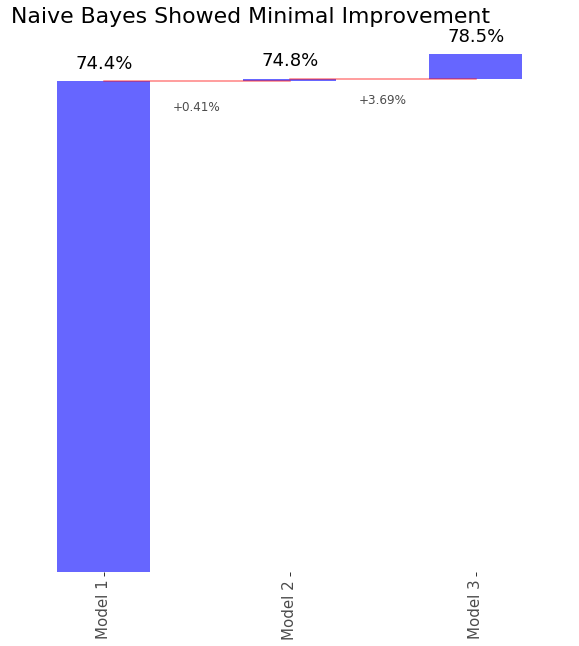

In [904]:
fig, ax = plt.subplots()
model_scores[['nb_water', 'nb_water_top']].plot(kind='bar', stacked=True, legend=False, ax=ax,
                                                figsize=(10,10), color = ['w', 'blue'], alpha=0.6,
                                                title="Naive Bayes Showed Minimal Improvement with New Features",
                                                layout='tight')
plt.xticks(size=15, alpha=0.7)
plt.yticks([])
plt.title('Naive Bayes Showed Minimal Improvement', size=22, position=(0,1), ha='left')
for item in ['left', 'right', 'top', 'bottom']:
    ax.spines[item].set_visible(False)
plt.plot([0, 1], [model_scores.loc['Model 1','Naive Bayes'],model_scores.loc['Model 1','Naive Bayes']],
         'r', lw=1.5, alpha=0.5)
plt.plot([1, 2], [model_scores.loc['Model 2','Naive Bayes'],model_scores.loc['Model 2','Naive Bayes']],
         'r', lw=1.5, alpha=0.5)
for i in range(3):
    plt.text(i, model_scores.iloc[i, 0]+.02, str(round(100*model_scores.iloc[i,0],1))+'%', ha='center', size=18)

plt.text(0.5, 0.7, '+' + str(round(100*model_scores.iloc[1,2],2)) + '%', size=12, alpha=0.7, ha='center')
plt.text(1.5, 0.71, '+' + str(round(100*model_scores.iloc[2,2],2)) + '%', size=12, alpha=0.7, ha='center')
plt.savefig('./Assets/nb_waterfall.png', bbox_inches='tight')

In [895]:
model_scores['log_water'] = [0, model_scores.iloc[0,1], model_scores.iloc[1, 1]]
model_scores['log_water_top'] = [model_scores.iloc[0,1], model_scores.iloc[1, 3], model_scores.iloc[2,3]]

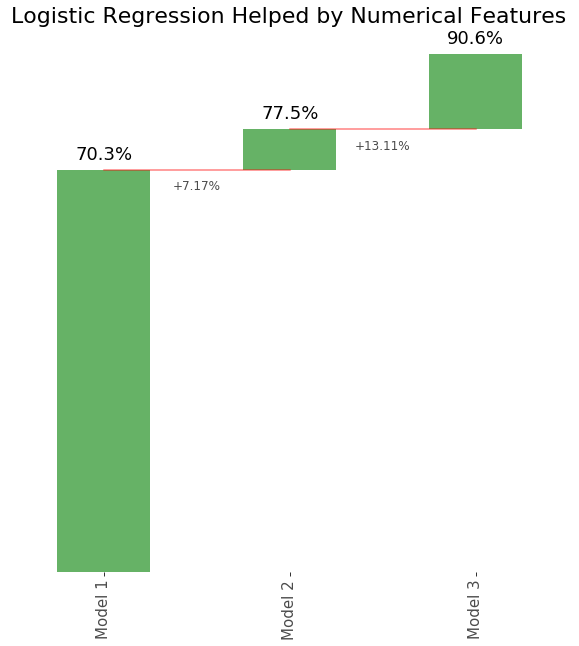

In [905]:
fig, ax = plt.subplots()
model_scores[['log_water', 'log_water_top']].plot(kind='bar', stacked=True, legend=False, ax=ax,
                                                figsize=(10,10), color = ['w', 'green'], alpha=0.6,
                                                layout='tight')
plt.xticks(size=15, alpha=0.7)
plt.yticks([])
plt.title('Logistic Regression Helped by Numerical Features', size=22, position=(0,1), ha='left')
for item in ['left', 'right', 'top', 'bottom']:
    ax.spines[item].set_visible(False)
plt.plot([0, 1], [model_scores.loc['Model 1','Logistic Regression'],model_scores.loc['Model 1','Logistic Regression']],
         'r', lw=1.5, alpha=0.5)
plt.plot([1, 2], [model_scores.loc['Model 2','Logistic Regression'],model_scores.loc['Model 2','Logistic Regression']],
         'r', lw=1.5, alpha=0.5)
for i in range(3):
    plt.text(i, model_scores.iloc[i, 1]+.02, str(round(100*model_scores.iloc[i,1],1))+'%', ha='center', size=18)

plt.text(0.5, 0.67, '+' + str(round(100*model_scores.iloc[1,3],2)) + '%', size=12, alpha=0.7, ha='center')
plt.text(1.5, 0.74, '+' + str(round(100*model_scores.iloc[2,3],2)) + '%', size=12, alpha=0.7, ha='center')
plt.savefig('./Assets/logreg_waterfall.png', bbox_inches='tight')

### Model 4: everything except comments

In [504]:
red_df.columns

Index(['archived', 'comments', 'domain', 'downs', 'gilded',
       'is_reddit_media_domain', 'is_self', 'is_video', 'num_comments',
       'num_crossposts', 'score', 'selftext', 'send_replies', 'subreddit',
       'title', 'ups', 'flair_text', 'post_hint_image', 'post_hint_link',
       'post_hint_rich:video', 'post_hint_self'],
      dtype='object')

In [506]:
features4 = [col for col in red_df.columns if col not in ['comments', 'subreddit']]
features4

['archived',
 'domain',
 'downs',
 'gilded',
 'is_reddit_media_domain',
 'is_self',
 'is_video',
 'num_comments',
 'num_crossposts',
 'score',
 'selftext',
 'send_replies',
 'title',
 'ups',
 'flair_text',
 'post_hint_image',
 'post_hint_link',
 'post_hint_rich:video',
 'post_hint_self']

In [507]:
X4 = red_df[features4]
y4 = red_df['subreddit']

In [508]:
X4 = pd.concat([X4.drop('domain', axis=1), pd.get_dummies(X4['domain'], prefix='domain_', drop_first=True)],
          axis=1)

In [509]:
X4.columns

Index(['archived', 'downs', 'gilded', 'is_reddit_media_domain', 'is_self',
       'is_video', 'num_comments', 'num_crossposts', 'score', 'selftext',
       ...
       'domain__whitehouse', 'domain__wikimedia', 'domain__wikipedia',
       'domain__wpengine', 'domain__wsj', 'domain__yahoo', 'domain__youtu',
       'domain__youtube', 'domain__zerohedge', 'domain__zimbio'],
      dtype='object', length=196)

For this model, there are multiple columns that I would like to vectorize. Instead of manually doing this, I will use the classes in the next two cells as well as the FeatureUnion class in order to create a pipeline that will programatically deal with this

In [510]:
class SampleExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, vars):
        self.vars = vars  # e.g. pass in a column names to extract

    def transform(self, X, y=None):
        if len(self.vars) > 1:
            return pd.DataFrame(X[self.vars]) # where the actual feature extraction happens
        else:
            return pd.Series(X[self.vars[0]])

    def fit(self, X, y=None):
        return self  # generally does nothing

class DenseTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None, **fit_params):
#         print X.todense()
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [511]:
X4.select_dtypes('object').columns

Index(['selftext', 'title', 'flair_text'], dtype='object')

In [512]:
col_renamer = {}
for col in X4.select_dtypes("int64").columns:
    col_renamer[col] = 'feature_' + col

col_renamer

{'archived': 'feature_archived',
 'downs': 'feature_downs',
 'gilded': 'feature_gilded',
 'is_reddit_media_domain': 'feature_is_reddit_media_domain',
 'is_self': 'feature_is_self',
 'is_video': 'feature_is_video',
 'num_comments': 'feature_num_comments',
 'num_crossposts': 'feature_num_crossposts',
 'score': 'feature_score',
 'send_replies': 'feature_send_replies',
 'ups': 'feature_ups'}

In [513]:
X4.rename(mapper=col_renamer, axis=1, inplace=True)

In [514]:
X4.columns

Index(['feature_archived', 'feature_downs', 'feature_gilded',
       'feature_is_reddit_media_domain', 'feature_is_self', 'feature_is_video',
       'feature_num_comments', 'feature_num_crossposts', 'feature_score',
       'selftext',
       ...
       'domain__whitehouse', 'domain__wikimedia', 'domain__wikipedia',
       'domain__wpengine', 'domain__wsj', 'domain__yahoo', 'domain__youtu',
       'domain__youtube', 'domain__zerohedge', 'domain__zimbio'],
      dtype='object', length=196)

In [515]:
# Create train/test split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=42)

In [516]:
other_cols = [col for col in X4.columns if col not in ['selftext', 'title', 'flair_text']]

In [460]:
# Create initial pipeline
pipe4 = Pipeline([
    
    # First step is feature union. This will concatenate the dataframes returned below
    ('features', FeatureUnion([
        
        # Create pipeline for selftext column
        ('selftext', Pipeline([
            
            # Pull out just the selftext column
            ('text', SampleExtractor(['selftext'])),
            
            # Count vectorize just the selftext column
            ('cv', CountVectorizer(stop_words='english')),
            
            # Convert sparse matrix to dense matrix
            ('dense', DenseTransformer())
        ])),
        
        # Create pipeline for title column and follow same steps as above
        ('title', Pipeline([
            ('text', SampleExtractor(['title'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),
        
        # Create pipeline for flair_text column and follow same steps as above
        ('flair_text', Pipeline([
            ('text', SampleExtractor(['flair_text'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),
        
        # Create pipeline for all other columns and just select the variables
        ('other', Pipeline([
            ('text', SampleExtractor(other_cols))
        ]))
        
    ])),
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [479]:
grid_params4 = {
    'logreg__penalty': ('l1', 'l2'),
    'logreg__C': (0.25, 0.275, 0.3)
}

gs4 = GridSearchCV(pipe4, grid_params4, verbose=1)

In [480]:
gs4.fit(X4_train, y4_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('selftext', Pipeline(memory=None,
     steps=[('text', SampleExtractor(vars=['selftext'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__penalty': ('l1', 'l2'), 'logreg__C': (0.25, 0.275, 0.3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [481]:
gs4.best_score_

0.896032831737346

In [482]:
gs4.best_params_

{'logreg__C': 0.25, 'logreg__penalty': 'l1'}

In [483]:
gs4.score(X4_train, y4_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9972640218878249

In [484]:
gs4.score(X4_test, y4_test)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9118852459016393

Interestingly, adding the additional infomration did not seem to help. I'm going to try doing this again by only scaling those features which are not 1 hot encoded and also not from the vectorizers

In [518]:
dummy_cols4 = list(X4.select_dtypes('uint8').columns)
len(dummy_cols4)

182

In [519]:
len(X4.columns)

196

In [520]:
[col for col in X4.columns if col not in dummy_cols4]

['feature_archived',
 'feature_downs',
 'feature_gilded',
 'feature_is_reddit_media_domain',
 'feature_is_self',
 'feature_is_video',
 'feature_num_comments',
 'feature_num_crossposts',
 'feature_score',
 'selftext',
 'feature_send_replies',
 'title',
 'feature_ups',
 'flair_text']

In [521]:
scale_cols4 = ['feature_archived', 'feature_downs', 'feature_gilded', 'feature_num_comments', 
               'feature_num_crossposts', 'feature_score', 'feature_ups']

In [522]:
remainder_cols = [col for col in other_cols if col not in scale_cols4]

In [647]:
pipe4_some_scale =  Pipeline([
    ('features', FeatureUnion([
        # Create pipeline for selftext column
        ('selftext', Pipeline([

            # Pull out just the selftext column
            ('text', SampleExtractor(['selftext'])),

            # Count vectorize just the selftext column
            ('cv', CountVectorizer(stop_words='english')),

            # Convert sparse matrix to dense matrix
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for title column and follow same steps as above
        ('title', Pipeline([
            ('text', SampleExtractor(['title'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for flair_text column and follow same steps as above
        ('flair_text', Pipeline([
            ('text', SampleExtractor(['flair_text'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for the remaining columns
        ('remaining', Pipeline([
            ('text', SampleExtractor(remainder_cols))
        ])),
        
        ('scale', Pipeline([
            ('text', SampleExtractor(scale_cols4)),
            ('ss', StandardScaler())
        ]))
    ])),
    ('logreg', LogisticRegression(verbose=1))
])

In [648]:
C_val4 = tuple(np.linspace(0.01, 1, 5))
grid_params4_scale = {
    'logreg__C': C_val4,
    'logreg__penalty': ('l1', 'l2'),
    'features__selftext__cv__ngram_range': ((1,1), (1,2)),
    'features__title__cv__ngram_range': ((1,1),(1,2),(1,3)),
    'features__flair_text__cv__ngram_range': ((1,1),(1,2),(1,3))
}

gs4_some_scale = GridSearchCV(pipe4_some_scale, grid_params4_scale, verbose=1)

gs4_some_scale.fit(X4_train, y4_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][L

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  3.5min finished


[LibLinear]

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('selftext', Pipeline(memory=None,
     steps=[('text', SampleExtractor(vars=['selftext'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logreg__C': (0.01, 0.2575, 0.505, 0.7525, 1.0), 'logreg__penalty': ('l1', 'l2'), 'features__selftext__cv__ngram_range': ((1, 1), (1, 2)), 'features__title__cv__ngram_range': ((1, 1), (1, 2), (1, 3)), 'features__flair_text__cv__ngram_range': ((1, 1), (1, 2), (1, 3))},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [649]:
gs4_some_scale_scale.best_score_

0.8967168262653898

In [650]:
gs4_some_scale.best_params_

{'features__flair_text__cv__ngram_range': (1, 1),
 'features__selftext__cv__ngram_range': (1, 1),
 'features__title__cv__ngram_range': (1, 1),
 'logreg__C': 0.505,
 'logreg__penalty': 'l2'}

In [651]:
gs4_some_scale.score(X4_test, y4_test)

0.9200819672131147

Again we have a slight improvement, but we still have room to grow. The last piece that we can include is the comments. This will result in a much larger model that will take significantly longer to fit, so first I'm going to try some bagging models using logistic regression, decision trees, and naive bayes

### Bagging Models expanding upon Model 4

In [599]:
pipe_bag = Pipeline([(
    'features', FeatureUnion([
        # Create pipeline for selftext column
        ('selftext', Pipeline([

            # Pull out just the selftext column
            ('text', SampleExtractor(['selftext'])),

            # Count vectorize just the selftext column
            ('cv', CountVectorizer(stop_words='english')),

            # Convert sparse matrix to dense matrix
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for title column and follow same steps as above
        ('title', Pipeline([
            ('text', SampleExtractor(['title'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for flair_text column and follow same steps as above
        ('flair_text', Pipeline([
            ('text', SampleExtractor(['flair_text'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for the remaining columns
        ('remaining', Pipeline([
            ('text', SampleExtractor(remainder_cols))
        ])),
        
        ('scale', Pipeline([
            ('text', SampleExtractor(scale_cols4)),
            ('ss', StandardScaler())
        ]))
    ])),
    ('bag', BaggingClassifier(DecisionTreeClassifier()))
])

bag_grid_params = {
    'bag__base_estimator__criterion': ('gini', 'entropy'),
    'bag__n_estimators': (10, 25, 50, 55, 65, 75),
}
gs_bag = GridSearchCV(pipe_bag, bag_grid_params, verbose=1)

In [600]:
gs_bag.fit(X4_train, y4_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('selftext', Pipeline(memory=None,
     steps=[('text', SampleExtractor(vars=['selftext'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bag__base_estimator__criterion': ('gini', 'entropy'), 'bag__n_estimators': (10, 25, 50, 55, 65, 75)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [601]:
gs_bag.best_score_

0.9548563611491108

In [602]:
gs_bag.best_params_

{'bag__base_estimator__criterion': 'entropy', 'bag__n_estimators': 25}

In [603]:
gs_bag.score(X4_train, y4_train)

0.9986320109439124

In [604]:
gs_bag.score(X4_test, y4_test)

0.9344262295081968

### Model 5: Comments

In [605]:
red_df['comments'] = red_df['comments'].map(lambda x: ' '.join(x))

In [615]:
type(red_df['comments'][0])

str

In [617]:
X5 = X4.copy()
X5['comments'] = red_df['comments']
y5 = red_df['subreddit']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, random_state=42)

In [671]:
pipe5 = Pipeline([(
    'features', FeatureUnion([
        # Create pipeline for selftext column
        ('selftext', Pipeline([

            # Pull out just the selftext column
            ('text', SampleExtractor(['selftext'])),

            # Count vectorize just the selftext column
            ('cv', CountVectorizer(stop_words='english')),

            # Convert sparse matrix to dense matrix
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for title column and follow same steps as above
        ('title', Pipeline([
            ('text', SampleExtractor(['title'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for flair_text column and follow same steps as above
        ('flair_text', Pipeline([
            ('text', SampleExtractor(['flair_text'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),
        
        # Create pipeline for comments column
        ('comments', Pipeline([
            ('text', SampleExtractor(['comments'])),
            ('cv', CountVectorizer(stop_words=stops, max_features=25000)),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for the remaining columns
        ('remaining', Pipeline([
            ('text', SampleExtractor(remainder_cols))
        ])),
        
        ('scale', Pipeline([
            ('text', SampleExtractor(scale_cols4)),
            ('ss', StandardScaler())
        ]))
    ])),
    ('bag', BaggingClassifier(DecisionTreeClassifier(), n_estimators=25))
])

grid_params5 = {
    'bag__base_estimator__max_depth': (10, 15)
}
gs5 = GridSearchCV(pipe5, grid_params5, verbose=1)

In [672]:
gs5.fit(X5_train, y5_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('selftext', Pipeline(memory=None,
     steps=[('text', SampleExtractor(vars=['selftext'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...estimators=25, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bag__base_estimator__max_depth': (10, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [661]:
gs5.best_score_

0.9822161422708618

In [662]:
gs5.best_params_

{'bag__n_estimators': 25}

In [663]:
gs5.score(X5_train, y5_train)

1.0

In [664]:
gs5.score(X5_test, y5_test)

0.9774590163934426

In [641]:
pipe5_logreg = Pipeline([(
    'features', FeatureUnion([
        # Create pipeline for selftext column
        ('selftext', Pipeline([

            # Pull out just the selftext column
            ('text', SampleExtractor(['selftext'])),

            # Count vectorize just the selftext column
            ('cv', CountVectorizer(stop_words='english')),

            # Convert sparse matrix to dense matrix
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for title column and follow same steps as above
        ('title', Pipeline([
            ('text', SampleExtractor(['title'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for flair_text column and follow same steps as above
        ('flair_text', Pipeline([
            ('text', SampleExtractor(['flair_text'])),
            ('cv', CountVectorizer(stop_words='english')),
            ('dense', DenseTransformer())
        ])),
        
        # Create pipeline for comments column
        ('comments', Pipeline([
            ('text', SampleExtractor(['comments'])),
            ('cv', CountVectorizer(stop_words=stops)),
            ('dense', DenseTransformer())
        ])),

        # Create pipeline for the remaining columns
        ('remaining', Pipeline([
            ('text', SampleExtractor(remainder_cols))
        ])),
        
        ('scale', Pipeline([
            ('text', SampleExtractor(scale_cols4)),
            ('ss', StandardScaler())
        ]))
    ])),
    ('logreg_bag', BaggingClassifier(base_estimator = LogisticRegression(verbose=1), verbose=1))
])

grid_params5_logreg = {
    'features__comments__cv__max_features': (15000, 25000, 35000),
    'features__comments__cv__ngram_range': ((1, 2), (1, 3)),
    'logreg_bag__base_estimator__C': (0.05, 0.075),
    'logreg_bag__base_estimator__penalty': ('l1', 'l2')
}
gs5_logreg = GridSearchCV(pipe5_logreg, grid_params5_logreg, verbose=1)

In [642]:
gs5_logreg.fit(X5_train, y5_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 27.6min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('selftext', Pipeline(memory=None,
     steps=[('text', SampleExtractor(vars=['selftext'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='...estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'features__comments__cv__max_features': (15000, 25000, 35000), 'features__comments__cv__ngram_range': ((1, 2), (1, 3)), 'logreg_bag__base_estimator__C': (0.05, 0.075), 'logreg_bag__base_estimator__penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [643]:
gs5_logreg.best_score_

0.9740082079343365

In [644]:
gs5_logreg.best_params_

{'features__comments__cv__max_features': 25000,
 'features__comments__cv__ngram_range': (1, 3),
 'logreg_bag__base_estimator__C': 0.05,
 'logreg_bag__base_estimator__penalty': 'l2'}

In [645]:
gs5_logreg.score(X5_test, y5_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


0.9713114754098361

In [629]:
gs5_logreg.best_params_

{'logreg_bag__base_estimator__C': 0.01,
 'logreg_bag__base_estimator__penalty': 'l2'}

In [630]:
gs5_logreg.score(X5_test, y5_test)

0.9774590163934426

#### Comments Only Based Models

In [693]:
X_com = red_df['comments']
y_com = red_df['subreddit']

In [694]:
X_com_train, X_com_test, y_com_train, y_com_test = train_test_split(X_com, y_com, random_state=8)

In [695]:
num_finder_cv = CountVectorizer()
num_finder_cv.fit(X_com_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [696]:
for col in num_finder_cv.get_feature_names():
    if col.isnumeric():
        stops.add(col)
len(stops)

2442

In [697]:
len(num_finder_cv.get_feature_names())

56635

In [698]:
steps = [('vect', CountVectorizer(stop_words = stops)),
         ('nb', MultinomialNB())]

pipe = Pipeline(steps)

grid_params = {
    'vect__max_features': (15000, 25000, 35000),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'vect__token_pattern': ('r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S', '(?u)\\b\\w\\w+\\b')
}

grid_4 = GridSearchCV(pipe, grid_params, verbose=1)

In [699]:
grid_4.fit(X_com_train, y_com_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 38.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'even', '1...kenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': (15000, 25000, 35000), 'vect__ngram_range': ((1, 1), (1, 2), (1, 3)), 'vect__token_pattern': ('r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S', '(?u)\\b\\w\\w+\\b')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [700]:
grid_4.best_score_

0.9233926128590971

In [701]:
grid_4.best_params_

{'vect__max_features': 15000,
 'vect__ngram_range': (1, 3),
 'vect__token_pattern': 'r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S'}

In [702]:
grid_4.score(X_com_test, y_com_test)

0.944672131147541

In [706]:
steps = [('vect', CountVectorizer(stop_words=stops)),
         ('logreg', LogisticRegression())]

pipe = Pipeline(steps)

grid_params = {
    'vect__max_features': (10000, 25000),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'vect__token_pattern': ('r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S', '(?u)\\b\\w\\w+\\b'),
    'logreg__C': (0.1, 0.5)
}

grid_5 = GridSearchCV(pipe, grid_params, verbose=1)

In [707]:
grid_5.fit(X_com_train, y_com_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  7.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'even', '1...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': (10000, 25000), 'vect__ngram_range': ((1, 2), (1, 3)), 'vect__token_pattern': ('r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S', '(?u)\\b\\w\\w+\\b'), 'logreg__C': (0.1, 0.5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [708]:
grid_5.best_score_

0.9746922024623803

In [709]:
grid_5.best_params_

{'logreg__C': 0.1,
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 2),
 'vect__token_pattern': 'r\\/\\w+|[a-zA-Z]+|[\\d\\.\\,]+|[\\.\\?\\!\\,]+\\S'}

In [710]:
grid_5.score(X_com_test, y_com_test)

0.9672131147540983

So predicting based just off of title and self-text is quite difficult to actually do. Even with tweaking hyperparameters, trying different tokenizers, the best accuracy I could get on the testing set was 75%. When I used the comments based model, my accuracy greatly increased. The maximum accuracy score jumped up to 97.7%, which is extremely accurate.

In [711]:
grid_5.best_estimator_.get_params()['steps'][1][1].coef_.T

array([[-0.13697669],
       [-0.00076557],
       [-0.004454  ],
       ...,
       [ 0.00288545],
       [-0.0022731 ],
       [-0.0016054 ]])

In [908]:
coefficients = pd.DataFrame(data=grid_5.best_estimator_.get_params()['steps'][1][1].coef_.T,
                            index = grid_5.best_estimator_.get_params()['steps'][0][1].get_feature_names())
coefficients.head()
coefficients.columns=['Coefficient']
coefficients['abs'] = abs(coefficients['Coefficient'])
coefficients['sign'] = coefficients['Coefficient'] > 0
coefficients.to_csv('./Assets/coefficients.csv')

In [907]:
coefficients.sort_values('abs', ascending=False).head(50)

,Coefficient,abs,sign
kek,-0.270937,0.270937,False
media,-0.268474,0.268474,False
liberals,-0.260590,0.260590,False
mueller,0.255132,0.255132,True
left,-0.250680,0.250680,False
hillary,-0.239570,0.239570,False
cnn,-0.234417,0.234417,False
trump,0.222023,0.222023,True
republicans,0.219221,0.219221,True
love,-0.198342,0.198342,False


In [911]:
coefficients[coefficients['sign']==False].sort_values('abs', ascending=False).head(25)

,Coefficient,abs,sign
kek,-0.270937,0.270937,False
media,-0.268474,0.268474,False
liberals,-0.260590,0.260590,False
left,-0.250680,0.250680,False
hillary,-0.239570,0.239570,False
cnn,-0.234417,0.234417,False
love,-0.198342,0.198342,False
geotus,-0.173902,0.173902,False
maga,-0.164972,0.164972,False
removed,-0.164494,0.164494,False


In [928]:
coefficients[coefficients['sign']==True].sort_values('abs', ascending=False).head(25)

,Coefficient,abs,sign
mueller,0.255132,0.255132,True
trump,0.222023,0.222023,True
republicans,0.219221,0.219221,True
https,0.196423,0.196423,True
republican,0.191249,0.191249,True
sub,0.178761,0.178761,True
guilty,0.167608,0.167608,True
gop,0.164102,0.164102,True
administration,0.153353,0.153353,True
hope,0.151132,0.151132,True


In [938]:
coefficients[coefficients['sign']==False].head(25)

,Coefficient,abs,sign
!!,-0.136977,0.136977,False
!! love,-0.000766,0.000766,False
!! trump,-0.004454,0.004454,False
!!!,-0.085022,0.085022,False
!!!!,-0.109888,0.109888,False
!!!!!,-0.036153,0.036153,False
!!!!!!,-0.008279,0.008279,False
!!!!!!!,-0.015263,0.015263,False
!!!!!!!!,-0.000702,0.000702,False
"!!!""",-0.005621,0.005621,False


## Predicting subreddit using Random Forests + Another Classifier

In [381]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [416]:
# Instantiate random forest model
rf = RandomForestClassifier(n_estimators=100, max_features=100)

In [417]:
# Instantiate second random forest model
rf_t = RandomForestClassifier()

In [418]:
# find cross-val scores for rf model based on titles
rf_score = cross_val_score(rf, X_train_cvect, y_train)
print(rf_score)
print(rf_score.mean())

[0.69877049 0.6550308  0.72895277]
0.6942513548995186


In [419]:
rf.fit(X_train_cvect, y_train)
rf.score(X_test_cvect, y_test)

0.7336065573770492

In [420]:
rf.score(X_train_cvect, y_train)

0.9993160054719562

In [392]:
# find cross-val scores for rf model based on titles
rf_t_score = cross_val_score(rf, X_train_tvect, y_train)
print(rf_t_score)
print(rf_t_score.mean())

[0.6557377  0.61601643 0.69199179]
0.6545819728234646


In [388]:
rf_t.fit(X_train_tvect, y_train)
rf_t.score(X_test_tvect, y_test)

0.680327868852459

In [504]:
cv = CountVectorizer()
cv.fit(X_train)
numeric_cols = [col for col in cv.get_feature_names() if col.isnumeric()]
len(cv.get_feature_names())

5753

In [502]:
from nltk.corpus import stopwords

In [513]:
stops = list(stopwords.words('english'))
stops.extend(numeric_cols)

In [514]:
rf_steps = [('vect', CountVectorizer()),
            ('rf', RandomForestClassifier())]

rf_pipe = Pipeline(rf_steps)

rf_params = {
    'vect__stop_words': ('english', stops, None),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    'vect__max_features': (1000, 2500, None),
    'rf__n_estimators': (5, 10, 15)
}

rfgs = GridSearchCV(rf_pipe, rf_params, verbose=1)

In [517]:
red_df.columns

Index(['archived', 'author', 'author_flair_text', 'comments', 'domain',
       'downs', 'gilded', 'id', 'is_reddit_media_domain', 'is_self',
       'is_video', 'link_flair_text', 'name', 'num_comments', 'num_crossposts',
       'post_hint', 'score', 'selftext', 'send_replies', 'subreddit', 'title',
       'ups', 'url'],
      dtype='object')

In [515]:
rfgs.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   54.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__stop_words': ('english', ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', '... (1, 2), (1, 3), (1, 4)), 'vect__max_features': (1000, 2500, None), 'rf__n_estimators': (5, 10, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_

In [507]:
rfgs.best_score_

0.7004103967168263

In [509]:
rfgs.score(X_test, y_test)

0.6823770491803278

In [484]:
rf_comments = RandomForestClassifier()

In [495]:
steps = [('vect', CountVectorizer()),
         ('rf', RandomForestClassifier())]

pipe = Pipeline(steps)

grid_params = {
    'vect__max_features': (17500, 22500),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'rf__n_estimators': [50, 60, 70],
    'vect__stop_words': ('english', None)
}

grid_6 = GridSearchCV(pipe, grid_params, verbose=1)

In [496]:
grid_6.fit(X_com_train, y_com_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  6.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': (17500, 22500), 'vect__ngram_range': ((1, 1), (1, 2)), 'rf__n_estimators': [50, 60, 70], 'vect__stop_words': ('english', None)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [497]:
grid_6.best_score_

0.9110807113543091

In [499]:
grid_6.best_params_

{'rf__n_estimators': 50,
 'vect__max_features': 17500,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [489]:
grid_6.score(X_com_test, y_com_test)

0.8954918032786885

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

In [913]:
from sklearn.ensemble import AdaBoostClassifier

In [914]:
ada = AdaBoostClassifier()

In [915]:
ada_params = {
    'n_estimators': [95, 100, 105, 110],
    'learning_rate': [0.65, 0.7, 0.75]
}
ada_grid = GridSearchCV(ada, param_grid = ada_params)

In [917]:
X7 = red_df['title'] + ' ' + red_df['selftext']
y7 = red_df['subreddit']

X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, random_state=42)

In [918]:
cvect7 = CountVectorizer(stop_words='english')
X7_train_cvect = cvect7.fit_transform(X7_train)
X7_test_cvect = cvect7.transform(X7_test)

In [919]:
ada_grid.fit(X7_train_cvect, y7_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [95, 100, 105, 110], 'learning_rate': [0.65, 0.7, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [920]:
ada_grid.best_score_

0.6764705882352942

In [921]:
ada_grid.best_params_

{'learning_rate': 0.65, 'n_estimators': 95}

The AdaBoost classifier performed poorly on the title and selftext data. It is possible that just this information alone was not robust enough to develop a strong model. Below I will try to use this same classifier with the comments data

In [922]:
steps = [('vect', CountVectorizer()),
         ('ada', AdaBoostClassifier())]

pipe = Pipeline(steps)

grid_params = {
    'vect__max_features': (17500, 22500),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'ada__learning_rate': [0.85, 0.95],
    'ada__n_estimators': [55, 65],
    'vect__stop_words': ('english', None)
}

grid_6 = GridSearchCV(pipe, grid_params, verbose=1)

In [923]:
grid_6.fit(X_com_train, y_com_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 10.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__max_features': (17500, 22500), 'vect__ngram_range': ((1, 1), (1, 2)), 'ada__learning_rate': [0.85, 0.95], 'ada__n_estimators': [55, 65], 'vect__stop_words': ('english', None)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [479]:
grid_6.best_score_

0.9829001367989056

In [480]:
grid_6.best_params_

{'ada__learning_rate': 0.95,
 'ada__n_estimators': 65,
 'vect__max_features': 17500,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [475]:
grid_6.best_score_

0.9808481532147743

In [476]:
grid_6.best_params_

{'ada__learning_rate': 0.9,
 'ada__n_estimators': 60,
 'vect__max_features': 20000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None,
 'vect__tokenizer': None}

In [482]:
grid_6.score(X_com_test, y_com_test)

0.9938524590163934

In [935]:
feat_importances = pd.DataFrame(grid_6.best_estimator_.steps[1][1].feature_importances_, columns=['importance'],
                                index=grid_6.best_estimator_.steps[0][1].get_feature_names())

In [937]:
feat_importances.sort_values('importance', ascending=False).head(20)

,importance
mueller,0.090909
kek,0.036364
trump,0.036364
republican,0.036364
left,0.036364
god,0.018182
fox,0.018182
corruption,0.018182
media,0.018182
shills,0.018182
